In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import math
from math import sqrt
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset= pd.read_csv('/home/das.puj/ML_Project/ML_dataframe.csv',parse_dates= ['Date'],index_col=['Date'], encoding= 'latin1')
dataset= dataset['1915':'2014'].resample('M').mean()
dataset=pd.DataFrame( dataset.Temperature)


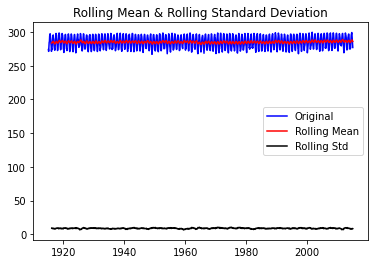

In [3]:
# Rolling Statistics

df = dataset
rolling_mean = df.rolling(window = 14).mean()
rolling_std = df.rolling(window = 14).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [5]:
# ADF Test -> null hypothesis = non-stationarity
# (hint: p-value is the probabiltiy that null hypothesis is true)

from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset)
print('p-value: {}'.format(result[1]))

p-value: 0.0011700770101247342



 Autocorrelation



In [6]:
h_df_original=pd.DataFrame(dataset)

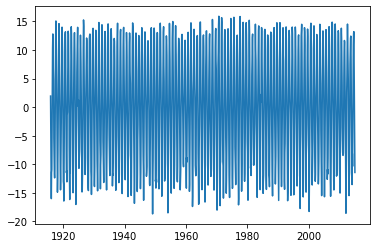

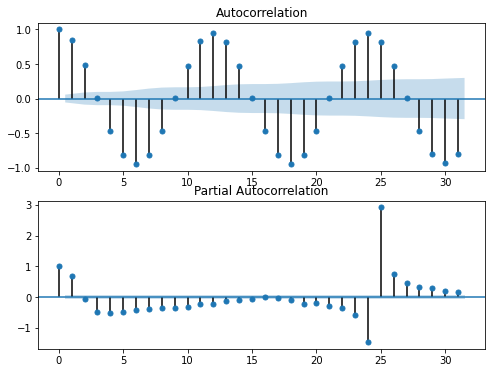

In [7]:
df_log = h_df_original.fillna(0)
df_log_stationary = df_log - df_log.rolling(window=10).mean()
plt.plot(df_log_stationary)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original time-series

fig, ax = plt.subplots(2, figsize=(8,6))
ax[0] = plot_acf(h_df_original, ax=ax[0])

# Calculate first-difference
df_log_stationary_diff = df_log_stationary - df_log_stationary.shift()
ax[1] = plot_pacf(df_log_stationary_diff.dropna(), ax=ax[1])

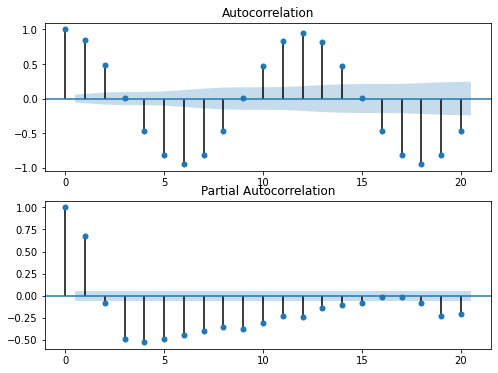

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original time-series

fig, ax = plt.subplots(2, figsize=(8,6))
ax[0] = plot_acf(dataset, ax=ax[0], lags=20)

# Calculate first-difference
df_log_stationary_diff = df_log_stationary - df_log_stationary.shift()
ax[1] = plot_pacf(df_log_stationary_diff.dropna(), ax=ax[1], lags=20)


Finding the Best ARIMA Model


In [10]:
from pmdarima import auto_arima 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df_log_stationary_diff.dropna(), start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5924.364, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5333.429, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5922.368, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5685.147, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5157.928, Time=1.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5410.238, Time=1.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5072.969, Time=2.12 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=5244.409, Time=0.90 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.82 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=5033.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1190
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2509.599
Date:                            Thu, 09 Dec 2021   AIC                           5031.198
Time:                                    19:05:10   BIC                           5061.628
Sample:                                         0   HQIC                          5042.671
                                           - 1190                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6097      0.027    -22.339      0.000      -0.663      -0.556
ar.L2         -0.3716      0.031    -11.802      0.000      -0.433      -0.310
ar.L3         -0.1867      0.029     -6.348      0.000      -0.244      -0.129
ar.S.L12      -0.6907      0.026    -26.949      0.000      -0.741      -0.640
ar.S.L24      -0.3764      0.026    -14.749      0.000      -0.426      -0.326
sigma2         4.1224      0.141     29.168      0.000       3.845       4.399
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                57.92
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.19
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
df_data = df_log_stationary_diff

train = df_data.iloc[:len(df_data)-240] 
test = df_data.iloc[len(df_data)-240:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(df_data,  
                order = (3, 0, 0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                 1200
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2587.866
Date:                            Thu, 09 Dec 2021   AIC                           5187.733
Time:                                    19:05:12   BIC                           5218.213
Sample:                                01-31-1915   HQIC                          5199.220
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6097      0.027    -22.339      0.000      -0.663      -0.556
ar.L2         -0.3716      0.031    -11.802      0.000      -0.433      -0.310
ar.L3         -0.1867      0.029     -6.348      0.000      -0.244      -0.129
ar.S.L12      -0.6907      0.026    -26.949      0.000      -0.741      -0.640
ar.S.L24      -0.3764      0.026    -14.749      0.000      -0.426      -0.326
sigma2         4.1224      0.141     29.168      0.000       3.845       4.399
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):                61.94
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.19
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

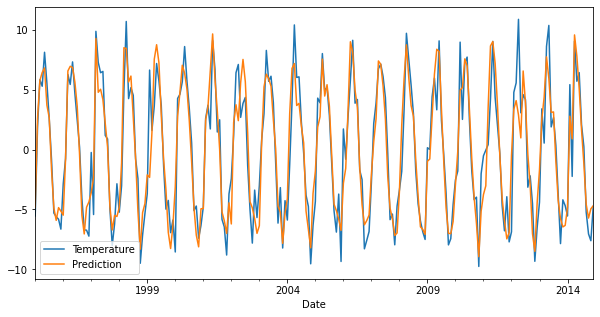

In [12]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
 
plt.rcParams.update({'figure.figsize': (10,5)}) #increase figure size
# plot predictions and actual values 

test = df_data.iloc[len(df_data)-240:]
test.plot(label= 'Truth')
predictions.plot(label= 'Prediction')  
plt.legend()
plt.show()

In [13]:
print('MSE: ', metrics.mean_squared_error(test, predictions))
print('MAE: ', metrics.mean_absolute_error(test, predictions))
print('R2: ', metrics.r2_score(test, predictions))
#print('Correlation: ', stats.pearsonr(test, predictions)[0])
print('RMSLE: ',metrics.mean_squared_log_error(np.absolute(test), np.absolute(predictions)))
print('MAPE: ',metrics.mean_absolute_percentage_error(test, predictions))

MSE:  4.300390856029549
MAE:  1.593584679322582
R2:  0.8527172436261977
RMSLE:  0.17317067988575838
MAPE:  1.080019796800041
